In [1]:
from preprocessed_mnist import load_dataset
# load data from keras
X_orig_train, y_orig_train, X_orig_val, y_orig_val, X_orig_test, y_orig_test = load_dataset()

Using TensorFlow backend.


In [2]:
import numpy as np
import tensorflow as tf
def preprocess():
    
    """
    flatten pixels to vector, transform y to one-hot-encoding form
    """
    
    X_train = X_orig_train.reshape(X_orig_train.shape[0], -1).T 
    X_val = X_orig_val.reshape(X_orig_val.shape[0], -1).T 
    X_test = X_orig_test.reshape(X_orig_test.shape[0], -1).T 
    y_train = np.eye(10)[y_orig_train.reshape(-1)].T
    y_val = np.eye(10)[y_orig_val.reshape(-1)].T
    y_test = np.eye(10)[y_orig_test.reshape(-1)].T
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [3]:
X_train, y_train, X_val, y_val, X_test, y_test = preprocess()
print(X_train.shape, y_train.shape)

(784, 50000) (10, 50000)


In [4]:
# random seed, so that the result will be consistent
seed = 10
# one hidden layer , and the number of units is 300
hidden_units = 300
output_units = 10
# create placeholder for input
X = tf.placeholder('float32', shape=(784, None))
y = tf.placeholder('float32', shape=(10, None))
# create parameters and forward propagation
W1 = tf.get_variable('W1', shape=[hidden_units, X_train.shape[0]], initializer=tf.contrib.layers.xavier_initializer(seed=seed))
b1 = tf.get_variable('b1', shape=[hidden_units, 1], initializer=tf.zeros_initializer())
Z1 = tf.matmul(W1, X) + b1
A1 = tf.nn.relu(Z1)
W2 = tf.get_variable('W2', shape=[output_units, hidden_units], initializer=tf.contrib.layers.xavier_initializer(seed=seed))
b2 = tf.get_variable('b2', shape=[output_units, 1], initializer=tf.zeros_initializer())
Z2 = tf.matmul(W2, A1) + b2

In [5]:
# regularization parameter lambda
lambd = 0.0001
# loss function
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf.transpose(y), logits=tf.transpose(Z2)))
loss = loss + tf.contrib.layers.l2_regularizer(lambd)(W1) + tf.contrib.layers.l2_regularizer(lambd)(W2)
# using learning rate decay
global_step = tf.Variable(0)
learning_rate = tf.train.exponential_decay(0.01, global_step, decay_steps=X_train.shape[1] // 32, decay_rate=0.9, staircase=True)
# optimizer
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss, global_step=global_step)

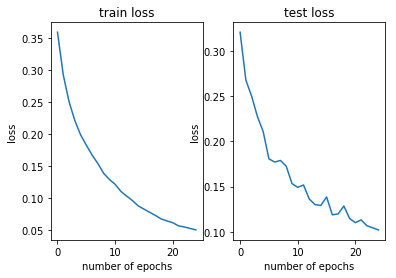

train accuracy: 99.801999%
test accuracy: 98.019999%
time needed: 5.227042mins


In [6]:
import math
import matplotlib.pyplot as plt
import time

def random_mini_batches(X, Y, mini_batch_size = 32, seed = 0):
    
    """
    return minibatches for mini-batch gradient descent
    """
    m = X.shape[1]
    mini_batches = []
    np.random.seed(seed)
    
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation]
    
    num_complete_minibatches = math.floor(m / mini_batch_size)
    for k in range(num_complete_minibatches):
        mini_batch_X = shuffled_X[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch_Y = shuffled_Y[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch_Y = shuffled_Y[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches


start = time.time()
init = tf.global_variables_initializer()
num_epochs = 25
mini_batch_size = 32
m = X_train.shape[1]
costs_train = []
costs_test = []

with tf.Session() as sess:
    
    sess.run(init)
    for epoch in range(num_epochs):
        
        # sum over train loss of each iteration
        minibatch_cost_train = 0
        # compute test loss for each epoch
        cost_test = 0
        num_minibatches = int(m / mini_batch_size)
        seed = seed + 1
        minibatches = random_mini_batches(X_train, y_train, mini_batch_size, seed)
        for minibatch in minibatches:
            mini_batch_X, mini_batch_Y = minibatch
            _, temp_cost = sess.run([optimizer, loss], feed_dict = {X: mini_batch_X, y: mini_batch_Y})
            minibatch_cost_train = minibatch_cost_train + temp_cost / num_minibatches
        
        cost_test = sess.run(loss, feed_dict={X: X_test, y: y_test})
        costs_train.append(minibatch_cost_train)
        costs_test.append(cost_test)
    
    # plot train loss and test loss
    plt.subplot(121)
    plt.title("train loss")
    plt.xlabel("number of epochs")
    plt.ylabel("loss")
    plt.plot(np.squeeze(costs_train))
    plt.subplot(122)
    plt.title("test loss")
    plt.xlabel("number of epochs")
    plt.ylabel("loss")
    plt.plot(np.squeeze(costs_test))
    plt.show()
    
    # compute train accuracy and test accuracy
    predict_op = tf.argmax(Z2, 0)
    correct_prediction = tf.equal(predict_op, tf.argmax(y, 0))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, 'float'))
    train_accuracy = accuracy.eval({X: X_train, y: y_train})
    test_accuracy = accuracy.eval({X: X_test, y:y_test})
    print("train accuracy: %f%%" % (train_accuracy*100))
    print("test accuracy: %f%%" % (test_accuracy*100))
    
end = time.time()
print("time needed: %fmins" %((end-start) / 60.))